In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms 

In [2]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(DEVICE, torch.cuda.get_device_name(), 'torch version : {}'.format(torch.__version__))

cuda NVIDIA GeForce GTX 1650 torch version : 1.12.0


In [3]:
BATCH_SIZES = 64
EPOCHS = 100 

In [4]:
data_transforms = {
    'train' : transforms.Compose([
        # 224 사이즈로 변경하되 이미지 내에서 랜덤으로 선택해 변경
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'val' : transforms.Compose([
        # 224 사이즈로 변경하되 이미지 내에서 랜덤으로 선택해 변경
        # 중앙기준으로 224 자름
        transforms.CenterCrop(224),
        # 256 크기로 변경
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]) 
}

image_datasets = {x : datasets.ImageFolder('../../data/hymenoptera_data/hymenoptera_data',
                                           data_transforms[x]) for x in ['train', 'val']}
dataloaders = { x : torch.utils.data.DataLoader(image_datasets[x], 
                                                batch_size = BATCH_SIZES,
                                                num_workers = 0,
                                                shuffle = True) for x in ['train', 'val']}

In [5]:
for X_train, y_train in dataloaders['train'] :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.FloatTensor torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

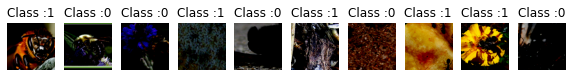

In [6]:
pltsize = 1

plt.figure(figsize=(pltsize*10, pltsize))
for i in range(10) :
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class :' + str(y_train[i].item()))
plt.show()

In [7]:
def train(model, train_loader, optimizer, log_intervals = 100) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_loss : {:.6f}'.format(
                Epoch, len(image) * batch_idx, len(train_loader.dataset), 
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [8]:
def evaluate(model, test_loader) :
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct * 100 / len(test_loader.dataset)
        return test_loss, test_accuracy

In [9]:
# del model

In [10]:
import torchvision.models as models 
model = models.resnet18(pretrained = False).cuda()
num_fts = model.fc.in_features
model.fc = nn.Linear(num_fts, 2)
model = model.cuda()

c:\Users\Admin\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# 학습률 낮게!
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
best_acc = 0
es = 0 

for Epoch in range(1, EPOCHS + 1) :
    train(model, dataloaders['train'], optimizer, log_intervals=3)
    test_loss, test_acc = evaluate(model, dataloaders['val'])
    print('\nEPOCH : {}, Test_loss : {:.6f}, Test_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_acc
    ))

    if test_acc > best_acc :
        best_acc = test_acc
        es = 0 
    else :
        es += 1

    if es >= 10 :
        print('최고 정확도 : {:.2f}'.format(best_acc))
        break

Train_Epoch : 1, [0 / 397](0%)	Train_loss : 1.030094
Train_Epoch : 1, [192 / 397](43%)	Train_loss : 0.818749
Train_Epoch : 1, [78 / 397](86%)	Train_loss : 0.727157

EPOCH : 1, Test_loss : 0.001796, Test_accuracy : 44.08%

Train_Epoch : 2, [0 / 397](0%)	Train_loss : 0.694957
Train_Epoch : 2, [192 / 397](43%)	Train_loss : 0.610629
Train_Epoch : 2, [78 / 397](86%)	Train_loss : 0.648147

EPOCH : 2, Test_loss : 0.001947, Test_accuracy : 45.59%

Train_Epoch : 3, [0 / 397](0%)	Train_loss : 0.609164
Train_Epoch : 3, [192 / 397](43%)	Train_loss : 0.679860
Train_Epoch : 3, [78 / 397](86%)	Train_loss : 0.638075

EPOCH : 3, Test_loss : 0.001602, Test_accuracy : 57.93%

Train_Epoch : 4, [0 / 397](0%)	Train_loss : 0.688249
Train_Epoch : 4, [192 / 397](43%)	Train_loss : 0.657596
Train_Epoch : 4, [78 / 397](86%)	Train_loss : 0.597280

EPOCH : 4, Test_loss : 0.001440, Test_accuracy : 59.19%

Train_Epoch : 5, [0 / 397](0%)	Train_loss : 0.701595
Train_Epoch : 5, [192 / 397](43%)	Train_loss : 0.658749
Tra